### Reference:
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [13]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [14]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [16]:
# load the dataset
# Load data
import base64
import requests
import yaml
url="http://172.31.47.222:4242/api/query?start=24h-ago&m=avg:Panel2Power"
headers = {'content-type': 'application/vnd.kafka.v1+json'}
r = requests.get(url, headers=headers)
d = (yaml.safe_load(r.text)[0]['dps'])
df3 = pd.DataFrame(list(d.items()))
df3.columns = ['timestamp', 'value']
df3['timestamp']=pd.to_datetime(df3['timestamp'], unit='s')
df3 = df3.sort_values(by=['timestamp'])
ts = pandas.Series(df3['value'].values, index=df3['timestamp'])

dataset = pandas.DataFrame(data=numpy.array(ts[0:801])).values
dataset = dataset.astype('float32')

In [17]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [27]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

536 265


In [28]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [36]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [37]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [31]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 3s - loss: 0.0000e+00
Epoch 2/100
 - 2s - loss: 0.0000e+00
Epoch 3/100
 - 2s - loss: 0.0000e+00
Epoch 4/100
 - 2s - loss: 0.0000e+00
Epoch 5/100
 - 2s - loss: 0.0000e+00
Epoch 6/100
 - 2s - loss: 0.0000e+00
Epoch 7/100
 - 2s - loss: 0.0000e+00
Epoch 8/100
 - 2s - loss: 0.0000e+00
Epoch 9/100
 - 2s - loss: 0.0000e+00
Epoch 10/100
 - 2s - loss: 0.0000e+00
Epoch 11/100
 - 2s - loss: 0.0000e+00
Epoch 12/100
 - 2s - loss: 0.0000e+00
Epoch 13/100
 - 2s - loss: 0.0000e+00
Epoch 14/100
 - 2s - loss: 0.0000e+00
Epoch 15/100
 - 2s - loss: 0.0000e+00
Epoch 16/100
 - 2s - loss: 0.0000e+00
Epoch 17/100
 - 2s - loss: 0.0000e+00
Epoch 18/100
 - 2s - loss: 0.0000e+00
Epoch 19/100
 - 2s - loss: 0.0000e+00
Epoch 20/100
 - 2s - loss: 0.0000e+00
Epoch 21/100
 - 2s - loss: 0.0000e+00
Epoch 22/100
 - 3s - loss: 0.0000e+00
Epoch 23/100
 - 2s - loss: 0.0000e+00
Epoch 24/100
 - 2s - loss: 0.0000e+00
Epoch 25/100
 - 2s - loss: 0.0000e+00
Epoch 26/100
 - 2s - loss: 0.0000e+00
Epoch 27/100
 - 2s - 

In [38]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.00 RMSE
Test Score: 14.17 RMSE


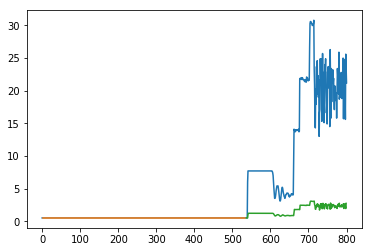

In [39]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()